In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Definir transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descargar conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dividir el conjunto de entrenamiento en 80% entrenamiento y 20% validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Definir la arquitectura de la SNN
class SNN(nn.Module):
    def __init__(self, hidden_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar las imágenes
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Función para entrenar y validar la SNN y registrar ambos errores
def train_and_validate_snn(hidden_size):
    model = SNN(hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5  # Número de épocas
    total_batches = len(train_loader) * epochs
    progress_bar = tqdm(total=total_batches, desc=f'Training SNN (hidden size: {hidden_size})')

    train_errors = []
    val_errors = []

    # Entrenamiento
    for epoch in range(epochs):  
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            progress_bar.update(1)

        # Calcular error de entrenamiento
        train_error = 1 - correct_train / total_train
        train_errors.append(train_error)

        # Validación
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_error = 1 - correct_val / total_val
        val_errors.append(val_error)

    progress_bar.close()
    total_params = sum(p.numel() for p in model.parameters())  # Número de parámetros

    return train_errors, val_errors, total_params


# Definir la arquitectura de la MLP
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28
        for hidden_size in hidden_layers:
            self.layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.layers.append(nn.Linear(input_size, 10))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# Función para entrenar y validar la MLP y registrar ambos errores
def train_and_validate_mlp(hidden_layers):
    model = MLP(hidden_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5
    total_batches = len(train_loader) * epochs
    progress_bar = tqdm(total=total_batches, desc=f'Training MLP (layers: {hidden_layers})')

    train_errors = []
    val_errors = []

    # Entrenamiento
    for epoch in range(epochs):  
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            progress_bar.update(1)

        # Calcular error de entrenamiento
        train_error = 1 - correct_train / total_train
        train_errors.append(train_error)

        # Validación
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_error = 1 - correct_val / total_val
        val_errors.append(val_error)

    progress_bar.close()
    total_params = sum(p.numel() for p in model.parameters())  # Número de parámetros

    return train_errors, val_errors, total_params

In [10]:
# Listas para guardar los errores finales (después de todas las épocas) y el número de parámetros
snn_train_final_errors, snn_val_final_errors, snn_params = [], [], []

# Experimentar con diferentes tamaños de capa para SNN
for hidden_size in [64, 128, 192, 256, 384, 512, 768, 1024]:
    train_errors, val_errors, total_params = train_and_validate_snn(hidden_size)
    
    # Guardar el error final (última época)
    snn_train_final_errors.append(train_errors[-1])
    snn_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    snn_params.append(total_params)

Training SNN (hidden size: 1024): 100%|██████████| 3750/3750 [00:42<00:00, 87.89it/s]


In [12]:
# Listas para guardar los errores finales (después de todas las épocas) y el número de parámetros
mlp_train_final_errors, mlp_val_final_errors, mlp_params = [], [], []

# Experimentar con diferentes arquitecturas MLP
for hidden_layers in [[64, 128], [128, 192], [192, 256], [256, 384], [384, 512], [512, 768], [768, 1024]]:
    train_errors, val_errors, total_params = train_and_validate_mlp(hidden_layers)
    
    # Guardar el error final (última época)
    mlp_train_final_errors.append(train_errors[-1])
    mlp_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    mlp_params.append(total_params)

Training MLP (layers: [768, 1024]): 100%|██████████| 3750/3750 [01:00<00:00, 62.14it/s]


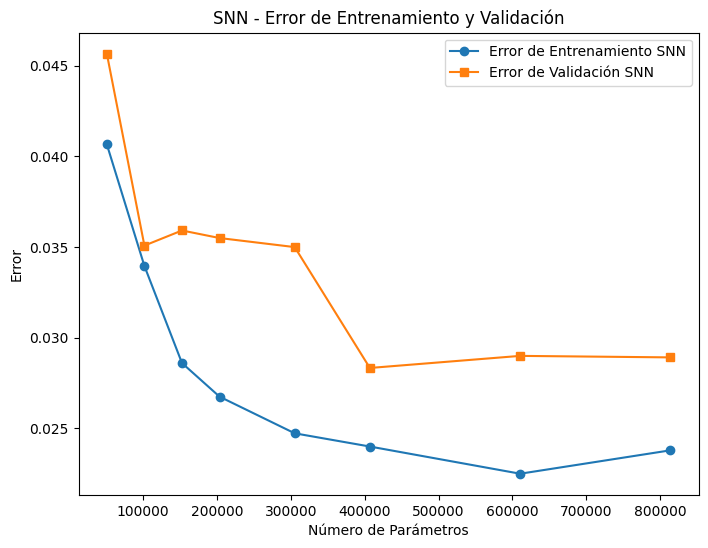

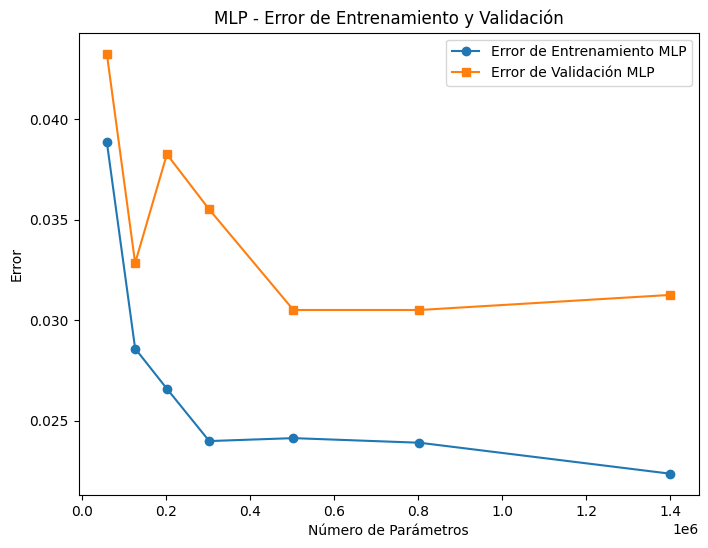

In [13]:
# Graficar los resultados
import matplotlib.pyplot as plt

# Gráfica de SNN
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(snn_params, snn_train_final_errors, 'o-', label='Error de Entrenamiento SNN')
plt.plot(snn_params, snn_val_final_errors, 's-', label='Error de Validación SNN')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('SNN - Error de Entrenamiento y Validación')
plt.legend()
plt.show()

# Gráfica de MLP
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(mlp_params, mlp_train_final_errors, 'o-', label='Error de Entrenamiento MLP')
plt.plot(mlp_params, mlp_val_final_errors, 's-', label='Error de Validación MLP')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('MLP - Error de Entrenamiento y Validación')
plt.legend()
plt.show()

Training SNN (hidden size: 64):   0%|          | 0/3750 [00:00<?, ?it/s]

Training MLP (layers: [1024, 1536]): 100%|██████████| 3750/3750 [01:04<00:00, 58.37it/s]


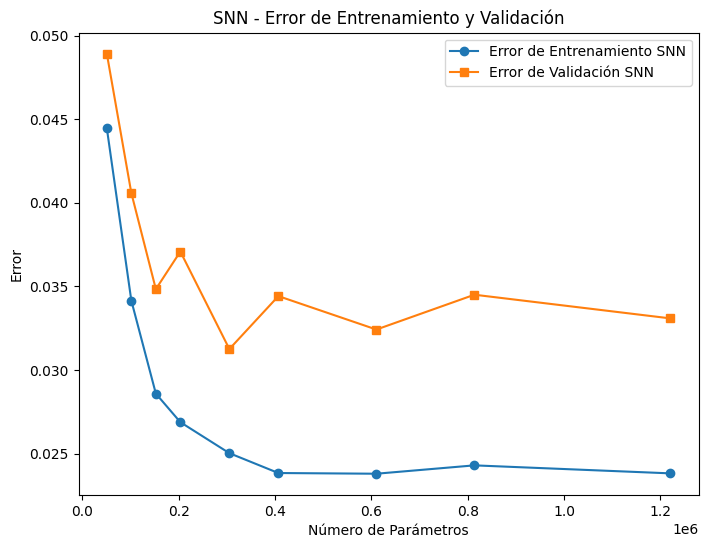

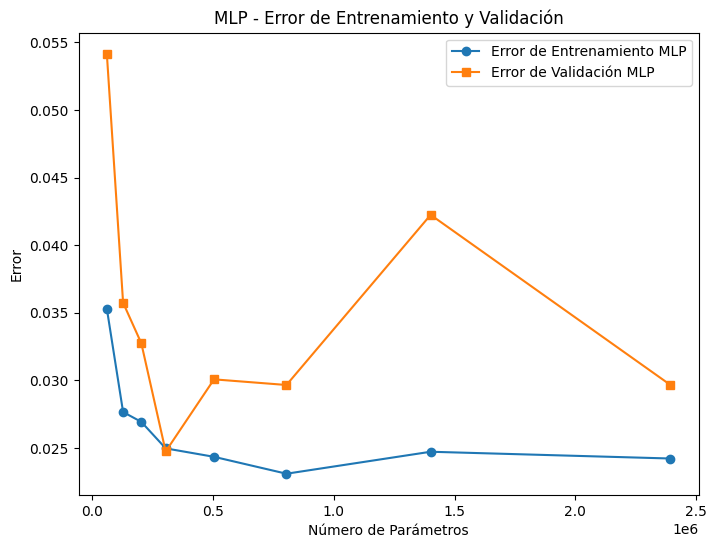

In [4]:
# Listas para guardar los errores finales (después de todas las épocas) y el número de parámetros
snn_train_final_errors, snn_val_final_errors, snn_params = [], [], []

# Experimentar con diferentes tamaños de capa para SNN
for hidden_size in [64, 128, 192, 256, 384, 512, 768, 1024, 1536]:
    train_errors, val_errors, total_params = train_and_validate_snn(hidden_size)
    
    # Guardar el error final (última época)
    snn_train_final_errors.append(train_errors[-1])
    snn_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    snn_params.append(total_params)

# Listas para guardar los errores finales (después de todas las épocas) y el número de parámetros
mlp_train_final_errors, mlp_val_final_errors, mlp_params = [], [], []

# Experimentar con diferentes arquitecturas MLP
for hidden_layers in [[64, 128], [128, 192], [192, 256], [256, 384], [384, 512], [512, 768], [768, 1024], [1024, 1536]]:
    train_errors, val_errors, total_params = train_and_validate_mlp(hidden_layers)
    
    # Guardar el error final (última época)
    mlp_train_final_errors.append(train_errors[-1])
    mlp_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    mlp_params.append(total_params)

# Graficar los resultados
import matplotlib.pyplot as plt

# Gráfica de SNN
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(snn_params, snn_train_final_errors, 'o-', label='Error de Entrenamiento SNN')
plt.plot(snn_params, snn_val_final_errors, 's-', label='Error de Validación SNN')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('SNN - Error de Entrenamiento y Validación')
plt.legend()
plt.show()

# Gráfica de MLP
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(mlp_params, mlp_train_final_errors, 'o-', label='Error de Entrenamiento MLP')
plt.plot(mlp_params, mlp_val_final_errors, 's-', label='Error de Validación MLP')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('MLP - Error de Entrenamiento y Validación')
plt.legend()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Definir una clase de MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Inicializar el modelo para [64, 128]
input_size = 784  # MNIST images are 28x28, flattened gives 784
hidden_layers = [64, 128]
output_size = 10  # MNIST tiene 10 clases

model = MLP(input_size, hidden_layers, output_size)

# Usa TensorBoard para registrar el grafo computacional
writer = SummaryWriter()

# Crea una entrada de ejemplo para el modelo
dummy_input = torch.randn(1, 784)  # Imagen de ejemplo en batch de 1
writer.add_graph(model, dummy_input)
writer.close()

print("Grafo guardado. Usa TensorBoard para visualizarlo.")


Grafo guardado. Usa TensorBoard para visualizarlo.
